# Extract downloaded NCIR data for model finetuning

This notebook extracts the tar files into train/val/test folders. Each has images and labels. The images are three channel gray-scale images and the mask are single channel pixel masks.

In [1]:
import os
import tarfile
from pathlib import Path
import shutil
from pycocotools import mask
from tqdm import tqdm
import shutil
from PIL import Image

In [2]:
def extract_tar_files(input_dir, output_dir):
    """
    Extract images and annotations from tar files into separate folders by split
    Args:
        input_dir: Directory containing tar files
        output_dir: Directory to save extracted files
    """
    # Create output directories for each split
    splits = ['train', 'val', 'test']
    for split in splits:
        os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, 'annotations'), exist_ok=True)
    
    # Process each tar file
    for tar_path in Path(input_dir).glob('*.tar'):
        # Determine which split this tar belongs to
        tar_name = tar_path.name.lower()
        current_split = None
        for split in splits:
            if split in tar_name:
                current_split = split
                break
                
        if current_split is None:
            print(f"Warning: Could not determine split for {tar_path}, skipping...")
            continue
            
        # Extract files
        with tarfile.open(tar_path, 'r') as tar:
            for member in tar.getmembers():
                if member.isdir():
                    continue
                    
                # Determine if file is image or annotation
                if member.name.endswith(('.jpg', '.jpeg', '.png')):
                    subdir = 'images'
                elif member.name.endswith('.json'):
                    subdir = 'annotations'
                else:
                    continue
                
                # Extract file to appropriate directory
                filename = os.path.basename(member.name)
                output_path = os.path.join(output_dir, current_split, subdir, filename)
                
                with tar.extractfile(member) as source:
                    with open(output_path, 'wb') as target:
                        shutil.copyfileobj(source, target)
                        
        print(f"Processed {tar_path}")

In [3]:
input_dir = "ncir_tar_data/"
output_dir = "extracted_ncir_data/"
extract_tar_files(input_dir, output_dir)

Processed ncir_tar_data/val-000000.tar
Processed ncir_tar_data/train-000000.tar


In [4]:
import json
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

def visualize_coco_segmentation(annotation_path, image_folder, image_id):
    # Load COCO annotations
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)
    coco = COCO(annotation_path)

    # Get image metadata
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_folder, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure and axis
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Generate a color cycle for different instances
    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))
    
    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    # Process each annotation
    for idx, ann in enumerate(anns):
        # Get category name
        cat_id = ann['category_id']
        cat_info = coco.loadCats([cat_id])[0]
        category_name = cat_info['name']
        
        # Get color for this instance
        color = colors[idx % 20][:3]  # Remove alpha channel

        # Create mask for this instance
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        
        segmentation = ann['segmentation']
        if isinstance(segmentation, list):  # Polygon segmentation
            # Convert polygons to mask
            for seg in segmentation:
                poly = np.array(seg, dtype=np.int32).reshape((-1, 2))
                cv2.fillPoly(mask, [poly], color=1)
        else:  # RLE segmentation
            rle = mask_utils.frPyObjects(segmentation, image_info['height'], image_info['width'])
            mask = mask_utils.decode(rle)

        # Get mask coordinates and calculate centroid
        coords = np.where(mask > 0)
        if len(coords[0]) > 0:  # Check if mask is not empty
            centroid_y = np.mean(coords[0])
            centroid_x = np.mean(coords[1])

            # Create masked array for visualization
            masked = np.ma.masked_where(mask == 0, mask)
            plt.imshow(masked, alpha=0.7, cmap=plt.matplotlib.colors.ListedColormap([color]))

            # Add label at centroid
            plt.text(centroid_x, centroid_y, category_name,
                    color='white', fontsize=12, 
                    bbox=dict(facecolor='black', alpha=0.7, pad=2),
                    horizontalalignment='center',
                    verticalalignment='center')

    plt.axis('off')
    plt.show()

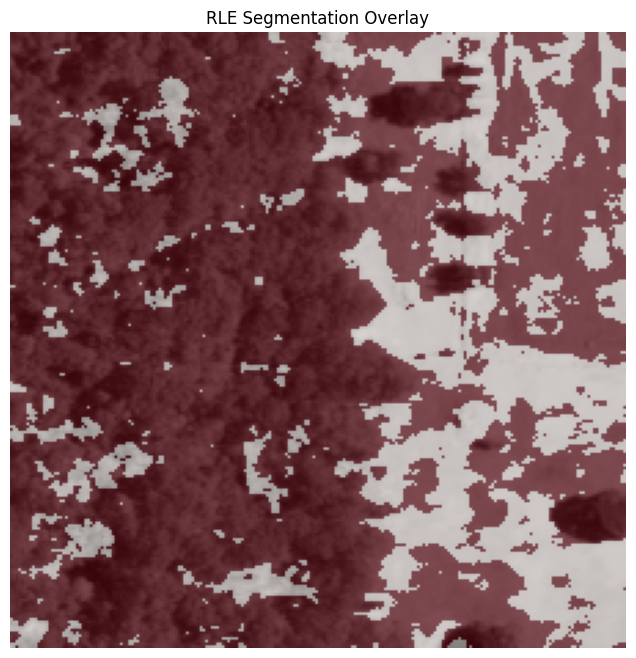

In [5]:
# Display mask over image
with open("./extracted_ncir_data/train/annotations/100171_r000_c000.json", 'r') as f:
    data = json.load(f)

image = cv2.imread("./extracted_ncir_data/train/images/100171_r000_c000.jpg")
img_mask = mask.decode(data["features"][0]["properties"]["segmentation"])

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.imshow(img_mask, alpha=0.5, cmap='Reds')
plt.axis("off")
plt.title("RLE Segmentation Overlay")
plt.show()

In [6]:
splits = ["train", "val", "test"]

# Save masks to new directory and copy images
for split in splits:
    coco_paths = os.listdir(f"extracted_ncir_data/{split}/annotations/")
    img_path = f"extracted_ncir_data/{split}/images/"
    hf_path = f"./hf_data_test/{split}/labels/"
    hf_img_path = f"./hf_data_test/{split}/images/"
    annotation_path = f"extracted_ncir_data/{split}/annotations/"

    # Ensure directories exist
    os.makedirs(hf_path, exist_ok=True)
    os.makedirs(hf_img_path, exist_ok=True)

    for annotation in tqdm(coco_paths):
        file_name = annotation.split("/")[-1].split(".")[0]
        img_name = file_name + ".jpg"
        
        # Save mask
        with open(f"{annotation_path}{annotation}", "r") as f:
            data = json.load(f)
        label = mask.decode(data["features"][0]["properties"]["segmentation"])
        mask_image = Image.fromarray(label)
        mask_image.save(hf_path + file_name + ".png")

        # Copy image to hf_img_path
        src_img_path = os.path.join(img_path, img_name)
        dest_img_path = os.path.join(hf_img_path, img_name)
        if os.path.exists(src_img_path):  # Ensure the image exists before copying
            shutil.copy2(src_img_path, dest_img_path)


100%|██████████| 15000/15000 [00:23<00:00, 626.25it/s]
0it [00:00, ?it/s]
